https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap15-Autoencoders/Chap15-Autoencoders.ipynb

텐서플로 구현 tensorflow==1.15.0

In [ ]:
from functools import partial
import os, sys
import numpy as np
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

################
# train params #
################
learning_rate = 0.001
n_digits = 60
n_epochs = 50
batch_size = 150

initializer = tf.variance_scaling_initializer()
dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu, 
    kernel_initializer=initializer)


# VAE
inputs = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = dense_layer(inputs, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3_mean = dense_layer(hidden2, n_hidden3, activation=None) # mean coding
hidden3_sigma = dense_layer(hidden2, n_hidden3, activation=None)  # sigma coding
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)  # gaussian noise
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = dense_layer(hidden3, n_hidden4)
hidden5 = dense_layer(hidden4, n_hidden5)
logits = dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

# loss
eps = 1e-10  # NaN을 반환하는 log(0)을 피하기 위함
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=inputs, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# saver
saver = tf.train.Saver()

In [ ]:
# train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, './model/my_model_variational.ckpt')
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        recon_loss_val, latent_loss_val, loss_val = sess.run([reconstruction_loss, 
                                                              latent_loss,
                                                              loss], feed_dict={inputs: batch_x})
        print('\repoch : {}, Train MSE : {:.5f},'.format(epoch, recon_loss_val),
               'latent_loss : {:.5f}, total_loss : {:.5f}'.format(latent_loss_val, loss_val))
    saver.save(sess, './model/my_model_variational.ckpt')
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

In [ ]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

## pytorch

https://cumulu-s.tistory.com/25  

https://github.com/PeterKim1/paper_code_review/blob/master/2.%20Auto-Encoding%20Variational%20Bayes(VAE)/2_Auto_Encoding_Variational_Bayes(VAE).ipynb

코랩버전

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)

current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')

# 적절한 Path를 설정
saved_loc = os.path.join('/content/drive/MyDrive/VAE_Result', current_time)
os.mkdir(saved_loc)

print("저장 위치: ", saved_loc)

writer = SummaryWriter(saved_loc)
EPOCHS = 50
BATCH_SIZE = 200

In [ ]:
# Transformer code
transformer = transforms.Compose([
            transforms.ToTensor()
])

# 여기도 적절한 저장 경로를 설정
# Loading trainset, testset and trainloader, testloader
trainset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = True,
                                        download = True, transform = transformer)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)


testset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = False,
                                        download = True, transform = transformer)

testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [ ]:
# sample check
sample, label = next(iter(trainloader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

In [ ]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size, hidden_size_1, hidden_size_2, latent_size):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(image_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc31 = nn.Linear(hidden_size_2, latent_size)
        self.fc32 = nn.Linear(hidden_size_2, latent_size)

        self.fc4 = nn.Linear(latent_size, hidden_size_2)
        self.fc5 = nn.Linear(hidden_size_2, hidden_size_1)
        self.fc6 = nn.Linear(hidden_size_1, image_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# VAE 모델을 객체로 만들어 준 후 Adam optimizer
VAE_model = VAE(28*28, 512, 256, 2).to(DEVICE)
optimizer = optim.Adam(VAE_model.parameters(), lr = 1e-3)

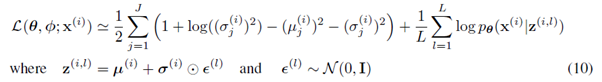

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [ ]:
# 학습코드
# VAE에는 label이 필요하지 않기 때문에 train_loader에서 나오는 label을 저장 x
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        BCE, KLD = loss_function(recon_batch, data, mu, logvar)

        loss = BCE + KLD

        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
        writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )

        loss.backward()

        train_loss += loss.item()

        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)
    ))        

In [ ]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(DEVICE)
            
            recon_batch, mu, logvar = model(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)

            loss = BCE + KLD

            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
            writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
            writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]]) # (16, 1, 28, 28)
                grid = torchvision.utils.make_grid(comparison.cpu()) # (3, 62, 242)
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [ ]:
def latent_to_image(epoch, model):
    with torch.no_grad():
        sample = torch.randn(64, 2).to(DEVICE)
        recon_image = model.decode(sample).cpu()
        grid = torchvision.utils.make_grid(recon_image.view(64, 1, 28, 28))
        writer.add_image("Latent To Image", grid, epoch)

In [ ]:
for epoch in tqdm(range(0, EPOCHS)):
    train(epoch, VAE_model, trainloader, optimizer)
    test(epoch, VAE_model, testloader)
    print("\n")
    latent_to_image(epoch, VAE_model)

writer.close()